In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from subprocess import check_output
plt.style.use('fivethirtyeight')
from tqdm import tqdm
from IPython.display import display
pd.options.display.max_columns = None
from collections import defaultdict
#print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
shots = pd.read_csv('./shot_logs_assignment.csv')
shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,Defender_Name,Player_Height,Defender_Height,Height_Diff,Player_Weight,Defender_Weight,Player_Age,Defender_Age,Player_Pos,Defender_Pos
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,alan anderson,182.5,195.0,-12.5,77.85,99.0,30,33,PG,SG
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,markel brown,182.5,187.5,-5.0,77.85,85.5,30,23,PG,SG
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,thaddeus young,182.5,0.0,182.5,77.85,0.0,30,0,PG,0


## RECOMMENDATION TASK
Aim to determine and recommend the best defender to guard any given offensive player.
1. Create user-item interaction matrix
2. Follow rating prediction task solution

In [3]:
player_list = shots.player_name.unique()
def_list = shots.Defender_Name.unique()
players = shots.groupby('player_name')
matrix = np.zeros((len(player_list), len(def_list)))
for i, each_player in tqdm(enumerate(player_list)):
    a = players.get_group(each_player)
    for _,each_def in a.iterrows():
        j = np.where(def_list == each_def["Defender_Name"])
        matrix[i,j] += each_def["PTS"]

281it [00:19, 14.14it/s]


In [4]:
all_ratings = []
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if matrix[i,j] != 0:
            all_ratings.append((player_list[i], def_list[j], matrix[i,j]))
print(len(all_ratings))

31750


In [19]:
from random import shuffle
ratings = all_ratings.copy()
shuffle(ratings)
ratings_train = ratings[:30000]
ratings_val = ratings[30000:]
ratings_per_player = defaultdict(list)
ratings_per_def = defaultdict(list)
for p,d,r in ratings_train:
    ratings_per_player[p].append((d,r))
    ratings_per_def[d].append((p,r))

In [20]:
trainRatings = [r[2] for r in ratings_train]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)
print(globalAverage)
validMSE = 0
for p,d,r in ratings_val:
    se = (r - globalAverage)**2
    validMSE += se

validMSE /= len(ratings_val)

print("Validation MSE (average only) = " + str(validMSE))

4.0152
Validation MSE (average only) = 11.485272411428701


In [21]:
alpha = globalAverage # Could initialize anywhere, this is a guess
betaP = {}
betaD = {}
for p in ratings_per_player:
    betaP[p] = 0

for d in ratings_per_def:
    betaD[d] = 0

In [22]:
def iterate(lamb):
    newAlpha = 0
    for p,d,r in ratings_train:
        newAlpha += r - (betaP[p] + betaD[d])
    alpha = newAlpha / len(ratings_train)
    
    for p in ratings_per_player:
        newBetaP = 0
        for d,r in ratings_per_player[p]:
            newBetaP += r - (alpha + betaD[d])
        betaP[p] = newBetaP / (lamb + len(ratings_per_player[p]))
        
    for d in ratings_per_def:
        newBetaD = 0
        for p,r in ratings_per_def[d]:
            newBetaD += r - (alpha + betaP[p])
        betaD[d] = newBetaP / (lamb + len(ratings_per_def[d]))
    
    mse = 0
    for p,d,r in ratings_train:
        prediction = alpha + betaP[p] + betaD[d]
        mse += (r - prediction)**2
        
    regularizer = 0
    for p in betaP:
        regularizer += betaP[p]**2
    for d in betaD:
        regularizer += betaD[d]**2
        
    mse /= len(ratings_train)
    return mse, mse + lamb*regularizer

In [23]:
plots_y = []
mse,objective = iterate(2)
plots_y.append(mse)
newMSE,newObjective = iterate(2)
plots_y.append(newMSE)
iterations = 2
while iterations < 100 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(2)
    plots_y.append(newMSE)
    iterations += 1
    #print("Objective after "
    #        + str(iterations) + " iterations = " + str(newObjective))
    #print("MSE after "
    #        + str(iterations) + " iterations = " + str(newMSE))

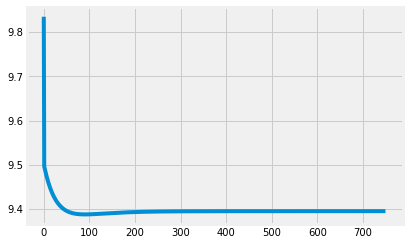

In [25]:
plt.plot(np.arange(750),plots_y)

In [26]:
validMSE = 0
for p,d,r in ratings_val:
    bp = 0
    bd = 0
    if p in betaP:
        bp = betaP[p]
    if d in betaD:
        bd = betaD[d]
    prediction = alpha + bp + bd
    validMSE += (r - prediction)**2

validMSE /= len(ratings_val)
print("Validation MSE = " + str(validMSE))

Validation MSE = 10.556991114756958


### SHOT PREDICTION USING LOGISTIC REGRESSION

To predict whether a shot is made or not on any given attempt we need to do first prepare the data.
1. Engineer features for each column
2. Create train and test split
3. Create y labels 

In [3]:
shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,Defender_Name,Player_Height,Defender_Height,Height_Diff,Player_Weight,Defender_Weight,Player_Age,Defender_Age,Player_Pos,Defender_Pos
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,alan anderson,182.5,195.0,-12.5,77.85,99.0,30,33,PG,SG
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,markel brown,182.5,187.5,-5.0,77.85,85.5,30,23,PG,SG
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,thaddeus young,182.5,0.0,182.5,77.85,0.0,30,0,PG,0


In [17]:
# Feature engineering

one_hot_player_pos = pd.get_dummies(shots["Player_Pos"])
one_hot_def_pos = pd.get_dummies(shots["Defender_Pos"])
player_name = pd.get_dummies(shots["player_name"])
def_name = pd.get_dummies(shots["Defender_Name"])
location_feature = list(shots.LOCATION.apply(lambda x: 0 if x == "A" else 1))
game_result_feature = list(shots.W.apply(lambda x: 1 if x == "W" else 0))
pts_feature = list(shots.PTS_TYPE.apply(lambda x: 1 if x == 3 else 0))
# shots["Height_Diff"] - Not used since some 0 values causes outliers.
# pts_in_game upto that shot
game_clock_feature = list(shots.GAME_CLOCK.apply(lambda x: int(x.strip().split(":")[0])*60 + int(x.strip().split(":")[1])))
features = np.column_stack([player_name, def_name, location_feature, game_result_feature, shots["PERIOD"], shots["DRIBBLES"],\
                            shots["SHOT_NUMBER"], shots["SHOT_DIST"], shots["TOUCH_TIME"], pts_feature,\
                            game_clock_feature, shots["CLOSE_DEF_DIST"], \
                            one_hot_player_pos, one_hot_def_pos])
labels = list(shots.SHOT_RESULT.apply(lambda x: 0 if x == "missed" else 1))

In [18]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

x_train = features[:120000]
y_train = labels[:120000]
x_test  = features[120000:]
y_test = labels[120000:]

#print(x_train[0])

model = LogisticRegression(C=0.01)
model.fit(x_train, y_train)
#weights = model.coef_
#print(weights)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

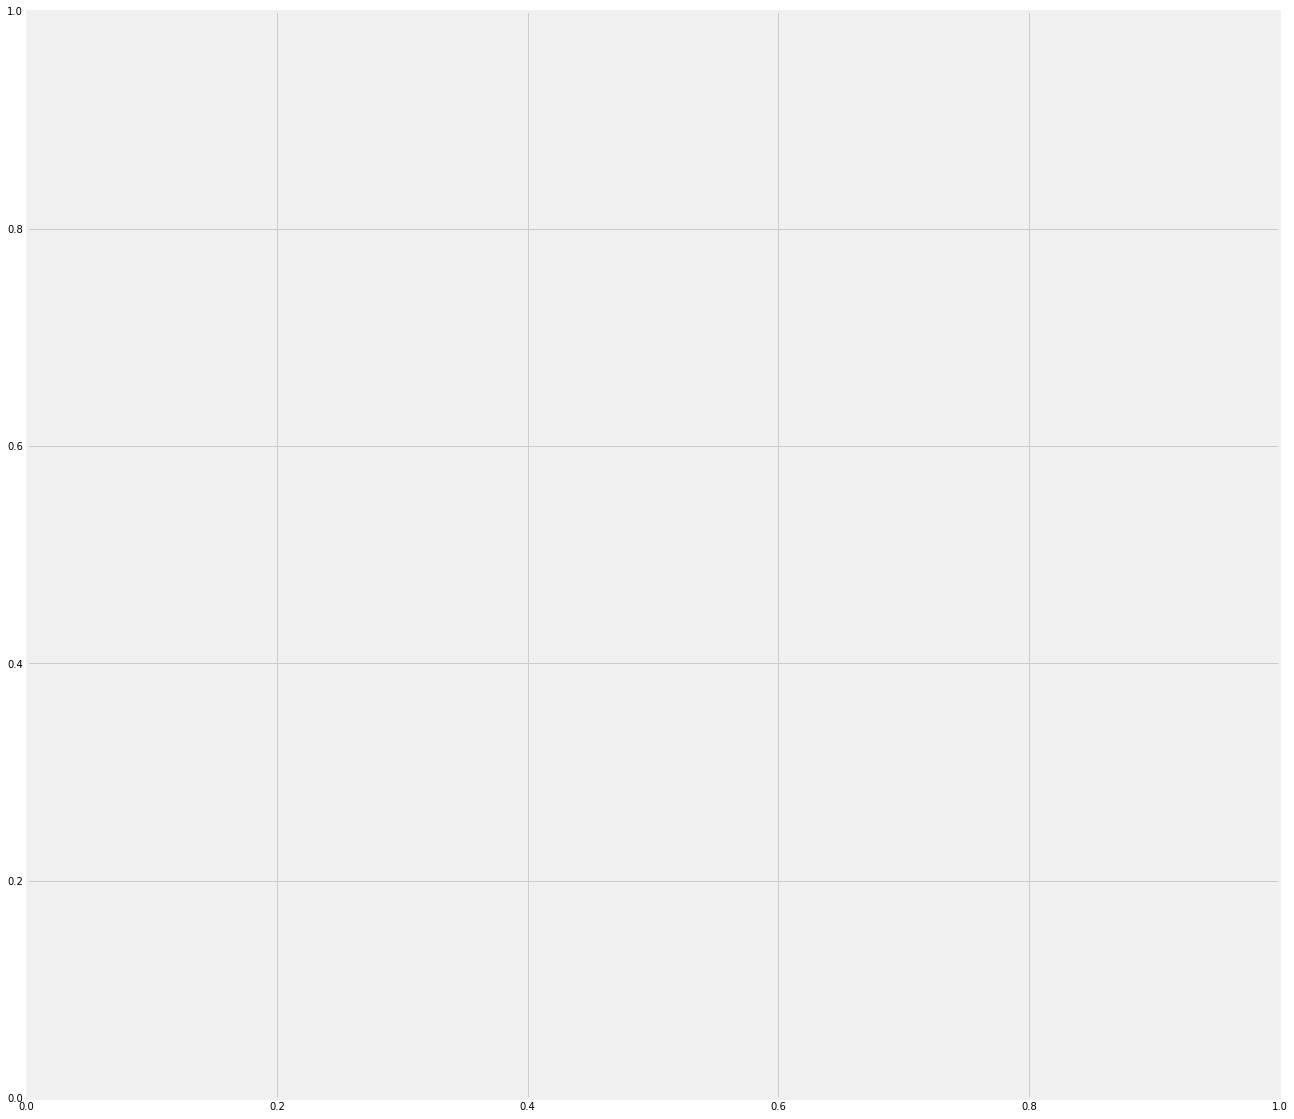

In [12]:
fig = plt.figure(figsize=(20,20))
plt.barh(range(features.shape[1]), weights[0])
plt.yticks(range(features.shape[1]), ["PLAYER_NAME", "LOCATION", "GAME RESULT", "PERIOD", "DRIBBLES", "SHOT NUMBER", \
                                      "SHOT DISTANCE", "TOUCH TIME", "NUMBER OF POINTS", "GAME CLOCK",\
                                      "CLOSEST DEFENDER DISTANCE", "HEIGHT DIFFERENCE", "PLAYER POSITION",\
                                      "DEFENDER POSITION"])
plt.title('Regression Coefficients')

In [19]:
# Testing and metrics evaluation
y_pred = model.predict(x_test)
accuracy = sum([y_pred[i] == y_test[i] for i in range(len(y_pred))])/len(y_pred)
print(accuracy)
c = confusion_matrix(y_test, y_pred)
print(c)

0.6260998884620151
[[3419 1023]
 [1994 1633]]


In [223]:
import math
for each_pair in new_list:
    if math.isnan(each_pair[0]):
        each_pair[0] = -100
        

In [224]:
new_list.sort(reverse=True)
print(new_list[:20])

[[0.3891369047619048, 'klay thompson'], [0.335245046923879, 'jonas valanciunas'], [0.317741935483871, 'mnta ellis'], [0.2736030828516377, 'jared dudley'], [0.21248339973439573, 'nene hilario'], [0.1969696969696969, 'dwayne wade'], [0.1875, 'caron butler'], [0.09926470588235292, 'jarrett jack'], [0.07407407407407407, 'thaddeus young'], [-0.036363636363636376, 'cody zeller'], [-0.31654676258992803, 'hollis thompson'], [-0.3543307086614173, 'kosta koufos'], [-0.40601503759398494, 'ryan anderson'], [-0.4470588235294118, 'ben mclemore'], [-0.48578811369509045, 'al horford'], [-100, 'patrick beverley'], [-100, 'jordan hill']]



0it [00:00, ?it/s]
1it [00:01,  1.08s/it]
2it [00:02,  1.08s/it]
3it [00:03,  1.07s/it]
4it [00:04,  1.06s/it]
5it [00:05,  1.05s/it]
6it [00:06,  1.06s/it]
7it [00:07,  1.07s/it]
8it [00:08,  1.07s/it]
9it [00:09,  1.06s/it]
10it [00:10,  1.08s/it]
11it [00:11,  1.08s/it]
12it [00:12,  1.07s/it]
13it [00:13,  1.08s/it]
14it [00:15,  1.09s/it]
15it [00:16,  1.10s/it]
16it [00:17,  1.10s/it]
17it [00:18,  1.08s/it]


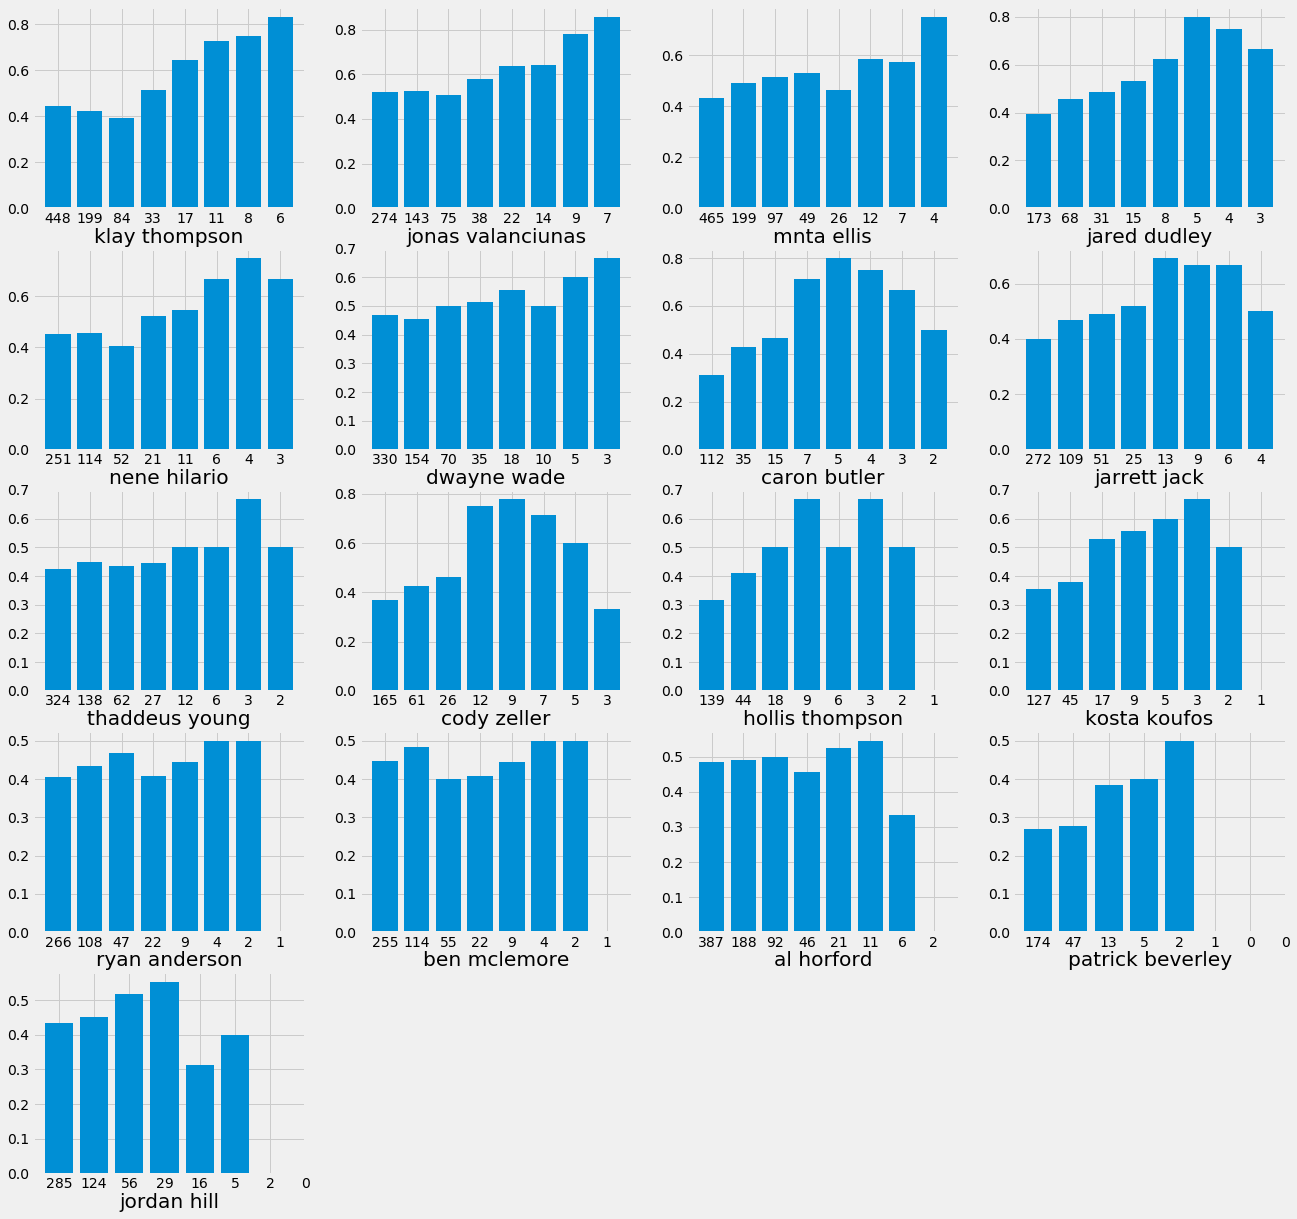

In [226]:
from operator import add
make_list = []
p = 9
fig = plt.figure(figsize=(20,20))
for n, each_player in tqdm(enumerate(new_list[:20])):
    make_percentage = []
    total_attempts = []
    a = hot_hand.loc[each_player]
    for j in range(1,p):# number of consecutive shots 
        total = 0
        made = 0
        for i in range(1,26-j+1):# shots taken (for a player in a game)
            total += (a[list(map(add, [i-1]*(j+1), range(1,(j+1))))]=='made').all(axis=1).sum()
            made +=  (a[list(map(add, [i-1]*(j+1), range(1,(j+2))))]=='made').all(axis=1).sum()
        #print('---n = ',j)
        #print('make percentage: ',made/float(total))
        make_percentage.append(made/float(total))
        total_attempts.append(total)
        #print('n shots were consecutively attempted before missing: ',total)
    plt.subplot(5,4,n+1)
    plt.bar(np.arange(p-1)+1, make_percentage)
    plt.xticks(np.arange(p-1)+1, total_attempts)
    plt.title(each_player[1], y = - 0.2)

## CLUTCH GENE EXPRESSION AND INVERSE CLUTCH GENE


In [252]:
shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,Defender_Name,Player_Height,Defender_Height,Height_Diff,Player_Weight,Defender_Weight,Player_Age,Defender_Age,Player_Pos,Defender_Pos,GAME_CLOCK_SECS,TIME_LEFT
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,alan anderson,182.5,195.0,-12.5,77.85,99.0,30,33,PG,SG,69,2229
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF,14,2174
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,bojan bogdanovic,182.5,200.0,-17.5,77.85,97.2,30,26,PG,SF,0,2160
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,markel brown,182.5,187.5,-5.0,77.85,85.5,30,23,PG,SG,707,2147
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,thaddeus young,182.5,0.0,182.5,77.85,0.0,30,0,PG,0,634,2074


In [454]:
shots["SHOT_CLOCK"] = shots.SHOT_CLOCK.apply(lambda x: 0 if math.isnan(x) else x)
shots["PERIOD"] = shots.PERIOD.apply(lambda x: int(x))
shots["GAME_CLOCK_SECS"] = shots.GAME_CLOCK.apply(lambda x: int(x.strip().split(":")[0])*60 \
                                                  + int(x.strip().split(":")[1]))
#shots["TIME_LEFT"] = 2880 - ((shots.PERIOD-1)*12*60 + (shots.GAME_CLOCK_SECS))

In [455]:
clutch_shots = shots[shots["PERIOD"] == 4]
clutch_shots = clutch_shots[clutch_shots["GAME_CLOCK_SECS"] < 2*60]
len(clutch_shots)

5287

In [456]:
clutch_players = clutch_shots.set_index(['player_name','SHOT_RESULT','SHOT_NUMBER'])

In [457]:
clutch_players.head()

GAME_ID                     MATCHUP  \
player_name   SHOT_RESULT SHOT_NUMBER                                         
brian roberts missed      5            21400783  FEB 10, 2015 - CHA vs. DET   
                          6            21400783  FEB 10, 2015 - CHA vs. DET   
                          14           21400768  FEB 08, 2015 - CHA vs. IND   
                          11           21400761    FEB 07, 2015 - CHA @ PHI   
                          12           21400761    FEB 07, 2015 - CHA @ PHI   

                                      LOCATION  W  FINAL_MARGIN  PERIOD  \
player_name   SHOT_RESULT SHOT_NUMBER                                     
brian roberts missed      5                  H  L           -28       4   
                          6                  H  L           -28       4   
                          14                 H  L            -1       4   
                          11                 A  L            -8       4   
                          12                 A  L            -8       4   

                                      GAME_CLOCK  SHOT_CLOCK  DRIBBLES  \
player_name   SHOT_RESULT SHOT_NUMBER                                    
brian roberts missed      5                 1:33        12.1         0   
                          6                 0:25         8.3         6   
                          14                0:01         0.0         5   
                          11                1:57        11.7         2   
                          12                0:56        20.2         3   

                                       TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
player_name   SHOT_RESULT SHOT_NUMBER                                    
brian roberts missed      5                   0.9       24.0         3   
                          6                   5.8        9.3         2   
                          14                  3.7       34.4         3   
                          11                  2.2       25.3         3   
                          12                  3.5       28.0         3   

                                         CLOSEST_DEFENDER  \
player_name   SHOT_RESULT SHOT_NUMBER                       
brian roberts missed      5            Dinwiddie, Spencer   
                          6                Jerebko, Jonas   
                          14                 Hill, George   
                          11                Noel, Nerlens   
                          12                 Frazier, Tim   

                                       CLOSEST_DEFENDER_PLAYER_ID  \
player_name   SHOT_RESULT SHOT_NUMBER                               
brian roberts missed      5                                203915   
                          6                                201973   
                          14                               201588   
                          11                               203457   
                          12                               204025   

                                       CLOSE_DEF_DIST  FGM  PTS  player_id  \
player_name   SHOT_RESULT SHOT_NUMBER                                        
brian roberts missed      5                       6.7    0    0     203148   
                          6                       3.6    0    0     203148   
                          14                      3.6    0    0     203148   
                          11                      5.6    0    0     203148   
                          12                      5.3    0    0     203148   

                                           Defender_Name  Player_Height  \
player_name   SHOT_RESULT SHOT_NUMBER                                     
brian roberts missed      5            spencer dinwiddie          182.5   
                          6                jonas jerebko          182.5   
                          14                 george hill          182.5   
                          11                nerlens noel          182.5   
             

In [458]:
clutch_shooter_list = clutch_shots.player_name.unique()
len(clutch_shooter_list)

280

In [459]:
clutch_players = clutch_shots.groupby('player_name')

In [460]:
clutch_efficiency = []
for each_player in tqdm(clutch_shooter_list):
    stats = clutch_players.get_group(each_player)
    fgm = 0
    fga = 0
    pts = 0
    for each_shot in stats.iterrows():
        if each_shot[1]["SHOT_RESULT"] == 'made':
            fgm += 1
            pts += int(each_shot[1]["PTS"])
            fga += 1
        else:
            fga += 1
    if fga > 10:
        clutch_efficiency.append([each_player, int(fgm), int(pts), int(fga), float(fgm/float(fga))])


100%|██████████| 280/280 [00:00<00:00, 334.84it/s]


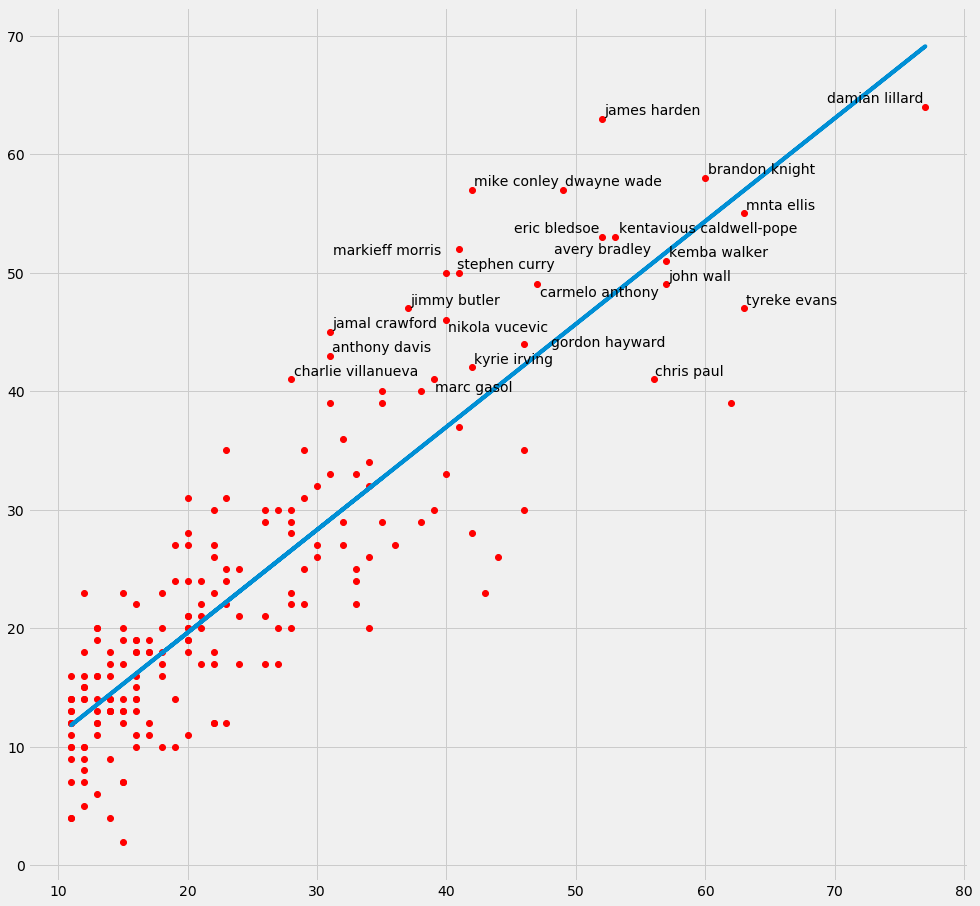

In [483]:
from adjustText import adjust_text
fig = plt.figure(figsize=(15,15))
#sorted_clutchness = sorted(clutch_efficiency, key=lambda x: x[4], reverse=True)
fga_p = []
fgm_p = []
pts_p = []
texts = []
for each_player in clutch_efficiency:
    fga_p.append(each_player[3])
    fgm_p.append(each_player[1])
    pts_p.append(each_player[2])
    plt.plot(each_player[3], each_player[2], 'ro')
    if((each_player[2] > 40)):
        #plt.annotate(each_player[0], xy= (each_player[3]+0.5, each_player[1]+0.5))
        texts.append(plt.text(each_player[3], each_player[2], each_player[0]))
adjust_text(texts) 
#print(fga_p)
#print(pts_p)
fit = np.polyfit(fga_p, pts_p,1)
fit_fn = np.poly1d(fit) 
plt.plot(fga_p, fit_fn(fga_p))
#plt.set(xlim=(0,maximum2), ylim=(0, maximum3))
# for i, txt in enumerate(sorted_clutchness):
#     plt.annotate(b[i,0], (b[i,2], b[i,3]))

R^2 on training... 0.010559211550277945
R^2 on test... 0.010315556729879716


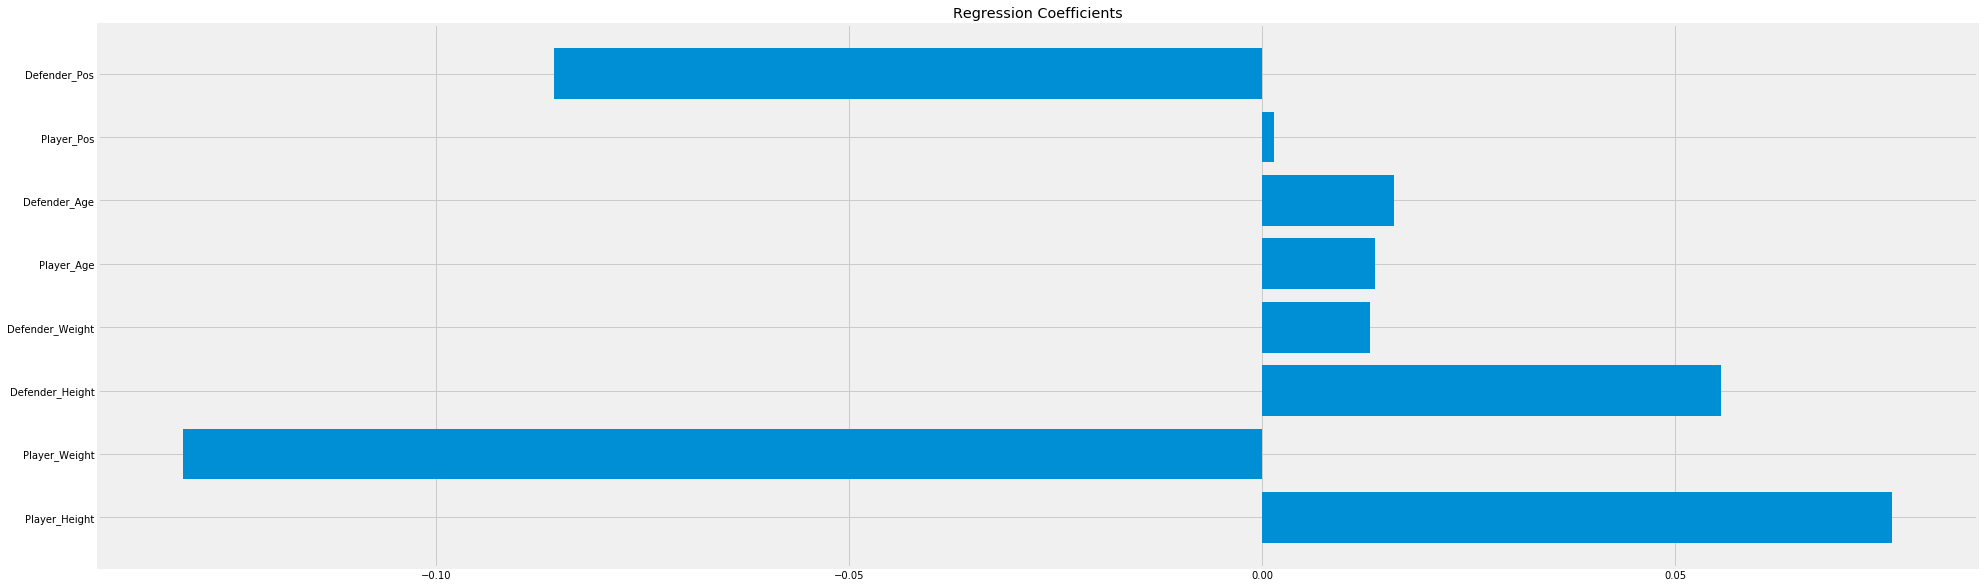

In [7]:
new_shots = shots[shots['Player_Weight']>0]
new_shots = new_shots[new_shots['Defender_Weight']>0]

new_shots = new_shots[new_shots['Player_Age'] >0]
new_shots = new_shots[new_shots['Defender_Age'] > 0]

def map_position(x):
    if x == 'PG':
        return 1
    if x == 'SG':
        return 2
    if x =='SF':
        return 3
    if x =='PF':
        return 4
    if x == 'C':
        return 5
    if x == 0:
        return 0

new_shots['Player_Pos'] = new_shots.Player_Pos.apply(lambda x: map_position(x))
new_shots['Defender_Pos']  = new_shots.Defender_Pos.apply(lambda x: map_position(x))
X = new_shots[['Player_Height','Player_Weight','Defender_Height','Defender_Weight','Player_Age','Defender_Age','Player_Pos','Defender_Pos']]#,'SHOT_DIST']]

X_std = StandardScaler().fit_transform(X)
y = new_shots.CLOSE_DEF_DIST*0.3048

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)

model.predict(X_test)
fig = plt.figure(figsize=(30,10))
plt.barh(range(len(X.columns)), model.coef_)
plt.yticks(range(len(X.columns)),['Player_Height','Player_Weight','Defender_Height','Defender_Weight','Player_Age','Defender_Age','Player_Pos','Defender_Pos','SHOT_DIST'], fontsize = 10)
plt.title('Regression Coefficients')

print('R^2 on training...',model.score(X_train,y_train))
print('R^2 on test...',model.score(X_test,y_test))